In [1]:
import tensorflow as tf

In [2]:
# Check if GPU is available and set TensorFlow to use it
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPUs available:", physical_devices)
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("TensorFlow is set to use GPU.")
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU found. Running on CPU.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is set to use GPU.


In [3]:

from tensorflow import keras    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


import dataset store from Data_preparation

In [4]:
train_path = './dataset/train'
valid_path = './dataset/val'
test_path = './dataset/test'

In [5]:
breeds = [
    "Holstein_cow", "Jersey_cow", "Angus_cow", "Brahman_cow", "Hereford_cow",
    "Simmental_cow", "Limousin_cow", "Guernsey_cow", "Charolais_cow", "Ayrshire_cow"
]

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=breeds, batch_size=10, shuffle=False)


Found 2802 images belonging to 10 classes.
Found 1069 images belonging to 10 classes.
Found 1083 images belonging to 10 classes.


if use "==" below the number must be same as number of image found above

In [6]:
assert train_batches.n >= 1000
assert valid_batches.n >= 300
assert test_batches.n >= 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10
assert train_batches.batch_size == valid_batches.batch_size == test_batches.batch_size == 10
assert train_batches.class_indices == valid_batches.class_indices == test_batches.class_indices

# 1. CNN

# 1.1. Training the model

In [7]:
imgs , labels = next(train_batches)
print("Shape of the image batch: ", imgs.shape)
print("Shape of the label batch: ", labels.shape)

Shape of the image batch:  (10, 224, 224, 3)
Shape of the label batch:  (10, 10)


In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..145.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..143.061].
Clipping input da

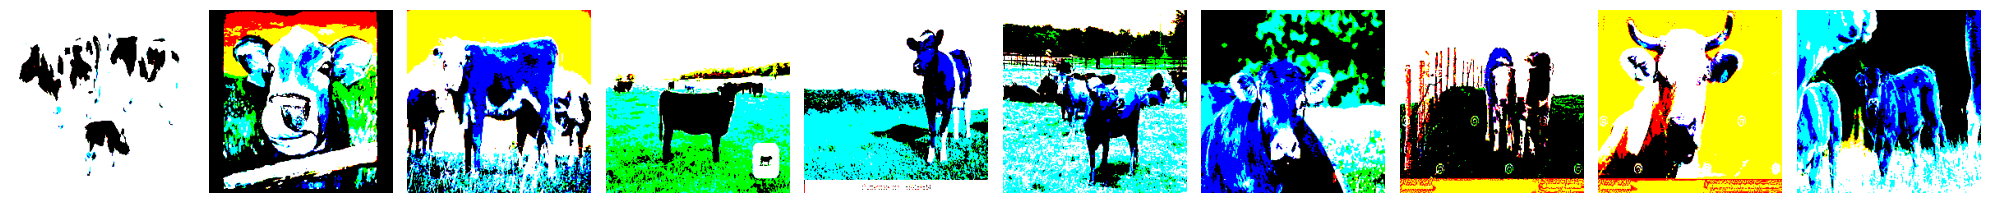

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [9]:
plotImages(imgs)
print(labels)

In [10]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 10)                2

In [12]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


# 2.Model:ResNet50, DenseNet121, MobileNetV3Large


In [13]:
import time
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [14]:
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    optimizer = Adam(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Helper function to calculate mAP
def mean_average_precision(y_true, y_pred):
    # y_true and y_pred should be numpy arrays
    # This is a simple implementation for multiclass, multi-label
    import sklearn.metrics
    return sklearn.metrics.average_precision_score(y_true, y_pred, average='macro')

input_shape = (224, 224, 3)
num_classes = len(breeds)
epochs = 50
results = {}

# ResNet50 

Training

In [16]:
print("Training ResNet50...")
resnet50_model = build_model(ResNet50, input_shape, num_classes)
start_time = time.time()
history = resnet50_model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs,
    verbose=2,
)
training_time = time.time() - start_time

Training ResNet50...
Epoch 1/50
281/281 - 129s - loss: 2.7945 - accuracy: 0.0914 - val_loss: 2.9147 - val_accuracy: 0.0851 - 129s/epoch - 459ms/step
Epoch 2/50
281/281 - 106s - loss: 2.7989 - accuracy: 0.0864 - val_loss: 2.9111 - val_accuracy: 0.0833 - 106s/epoch - 379ms/step
Epoch 3/50
281/281 - 106s - loss: 2.7847 - accuracy: 0.0949 - val_loss: 2.9050 - val_accuracy: 0.0804 - 106s/epoch - 378ms/step
Epoch 4/50
281/281 - 106s - loss: 2.7861 - accuracy: 0.0960 - val_loss: 2.9100 - val_accuracy: 0.0814 - 106s/epoch - 377ms/step
Epoch 5/50
281/281 - 106s - loss: 2.7855 - accuracy: 0.0924 - val_loss: 2.9110 - val_accuracy: 0.0833 - 106s/epoch - 377ms/step
Epoch 6/50
281/281 - 106s - loss: 2.7939 - accuracy: 0.0928 - val_loss: 2.9044 - val_accuracy: 0.0795 - 106s/epoch - 378ms/step
Epoch 7/50
281/281 - 106s - loss: 2.7878 - accuracy: 0.0935 - val_loss: 2.9080 - val_accuracy: 0.0814 - 106s/epoch - 378ms/step
Epoch 8/50
281/281 - 106s - loss: 2.7888 - accuracy: 0.0967 - val_loss: 2.9107 - va

Evaluate on validation set

In [17]:
# Evaluate ResNet50 on validation set and store results for later use
val_imgs, val_labels = next(valid_batches)
val_preds = resnet50_model.predict(val_imgs)
acc = np.mean(np.argmax(val_preds, axis=1) == np.argmax(val_labels, axis=1))
mAP = mean_average_precision(val_labels, val_preds)
results['ResNet50'] = {
    'training_time_sec': training_time,
    'val_accuracy': acc,
    'val_mAP': mAP,
    'history': history,
    'val_imgs': val_imgs,
    'val_labels': val_labels,
    'val_preds': val_preds
}
# resnet50_model is now available for later use

1/1 [==============================] - 1s 839ms/step


c:\Users\Mansal\anaconda3\envs\Mansal\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\Mansal\anaconda3\envs\Mansal\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [21]:
with open('results_resnet50.pkl', 'wb') as file:
    pickle.dump(results, file)

INFO:tensorflow:Assets written to: ram://8e9cb905-29f7-471d-9672-f20095bb319f/assets


INFO:tensorflow:Assets written to: ram://8e9cb905-29f7-471d-9672-f20095bb319f/assets


Display training time, accuracy, and mAP for all models separately

In [19]:
for model_name, res in results.items():
    print(f"Model: {model_name}")
    print(f"  Training Time: {res['training_time_sec']:.2f} seconds")
    print(f"  Validation Accuracy: {res['val_accuracy']:.4f}")
    print(f"  Validation mAP: {res['val_mAP']:.4f}")
    print("-" * 40)

Model: ResNet50
  Training Time: 5336.37 seconds
  Validation Accuracy: 0.2000
  Validation mAP: 0.2184
----------------------------------------


In [20]:
resnet50_model.summary()
# Save the ResNet50 model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              